### Image processing

In [1]:
import imageio
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
def preprocess_imagery(path):
    '''
    Pre process satellite imagery. We check for nans in the composite images,
    and then we load them into the [0,1] range.
    Input: TIF files downloaded from GEE (224x224x7)
    '''
    #reading image
    path=str(path).strip('b').strip("'")
    image=imageio.imread(path)
    if np.sum(np.isnan(image))>0:
        #print(str(np.sum(np.isnan(image)))+"nans found")
        #taking the mean of the image, per channel
        mean=np.nanmean(image,axis=(0,1))
        #replacing NaN with per channel mean
        replacement=np.isnan(image)*mean
        image[np.isnan(image)]=replacement[np.isnan(image)]  
        #print(str(np.sum(np.isnan(image)))+"nans found")
        nan_channels = np.all(np.isnan(image), axis=(0, 1))
        # Replacing NaN with 0 where all values in a channel are NaN
        image[:, :, nan_channels] = np.nan_to_num(image[:, :, nan_channels])
        image=image/255
    return image

In [3]:
image_files = [f for f in os.listdir("../GEE_Images")]
image_files=image_files
len(image_files)

51782

In [9]:
#run when mp10.txt not present
image_info=[]
for image in image_files:
    name,_=os.path.splitext(image)
    image_info.append(['_'.join(name.split(' ')[0].split('_')[:-1]),name.split(' ')[0].split('_')[-1]])
df=pd.read_csv('processed_data.csv')
mp10_0=[]
mp10_1=[]
mp10_2=[]
a=0
image_files_0=[]
image_files_1=[]
image_files_2=[]
for info in image_info:
    value=(df[(df['station']==info[0]) & (df['Date']==info[1])])
    if value['region'].values[0]==0:
        mp10_0.append(value['mp10'].values[0])
        image_files_0.append(image_files[a])
        
    elif value['region'].values[0]==1:
        mp10_1.append(value['mp10'].values[0])
        image_files_1.append(image_files[a])
        
    else:
        mp10_2.append(value['mp10'].values[0])
        image_files_2.append(image_files[a])
    a+=1


In [10]:
with open("mp10_0.txt", "w") as f:
  for value in mp10_0:
    f.write(str(value) + "\n")
with open("mp10_1.txt", "w") as f:
  for value in mp10_1:
    f.write(str(value) + "\n")
with open("mp10_2.txt", "w") as f:
  for value in mp10_2:
    f.write(str(value) + "\n")
with open("image_list_0.txt", "w") as f:
  for value in image_files_0:
    f.write(str(value) + "\n")
with open("image_list_1.txt", "w") as f:
  for value in image_files_1:
    f.write(str(value) + "\n")
with open("image_list_2.txt", "w") as f:
  for value in image_files_2:
    f.write(str(value) + "\n")

In [4]:
with open('mp10_capping.txt', 'r') as f:
  mp10 = [float(line.strip()) for line in f]
mp10=np.array(mp10[:20000])

In [5]:

for a in range(len(image_files)):
    image_files[a]="../GEE_Images/"+image_files[a]
train_image_files, test_image_files, train_mp10, test_mp10 = train_test_split(
    image_files, mp10, test_size=0.2, random_state=42)


In [6]:
test_mp10=np.array(test_mp10)

### Model using one NN 224,224,6 

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape):
    model = models.Sequential()

    # Capa convolucional
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    # Capa de pooling
    model.add(layers.AveragePooling2D((2, 2)))

    # Otras capas convolucionales y de pooling para aumentar la profundidad
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))

    # Aplanar los datos para alimentar la capa densa
    model.add(layers.Flatten())

    # Capas densas para la parte final de la red
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Regularización con dropout
    model.add(layers.Dense(1, activation='linear'))  # Capa de salida con activación lineal para valores float

    return model

# Crear el modelo
input_shape = (224, 224, 6)
model = build_model(input_shape)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
model.summary()


c:\Users\benja\anaconda3\envs\ee\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 111, 111, 16)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 54, 54, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 26, 26, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 12, 12, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 614,097 (2.34 MB)

 Trainable params: 614,097 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from keras.utils import plot_model
# Just showing all possible argument for newcomer.  
tf.keras.utils.plot_model(
    model,                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [11]:
# Dividir el conjunto de datos en partes (si es necesario)
batch_size = 4000
epochs = 15
full_history=[]
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor((preprocess_imagery(imgs)),dtype=tf.float32))
    images=np.array(images)
    history=model.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = np.array(mp10[num_parts * batch_size:])
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor((preprocess_imagery(imgs)),dtype=tf.float32))
    images=np.array(images)
    history=model.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history.append([history.history['loss'],history.history['mae']])

Part:  1


C:\Users\benja\AppData\Local\Temp\ipykernel_1972\3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
C:\Users\benja\AppData\Local\Temp\ipykernel_1972\3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 233ms/step - loss: 2093271.0000 - mae: 451.4087
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - loss: 1336.1152 - mae: 28.9275
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - loss: 1132.8407 - mae: 26.2542
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 230ms/step - loss: 1210.8640 - mae: 26.4785
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - loss: 1004.8624 - mae: 24.6921
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - loss: 1092.3752 - mae: 25.2672
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - loss: 1101.6962 - mae: 25.2048
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - loss: 1220.0372 - mae: 26.7193
Epoch 9/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - loss: 1149.8551 - mae: 25.7728
Epoch 10/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - loss: 1112.9729 - mae: 25.9009
Epoch 11/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - loss: 1136.8291 - mae: 26.0128
Epoch 12/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms

In [15]:
# Evaluamos el modelo
images=[]
for imgs in test_image_files:
    images.append(tf.convert_to_tensor((preprocess_imagery(imgs)),dtype=tf.float32))
images=np.array(images)
test_loss = model.evaluate(images, test_mp10)
print('Test Loss:', test_loss)


C:\Users\benja\AppData\Local\Temp\ipykernel_1972\3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
C:\Users\benja\AppData\Local\Temp\ipykernel_1972\3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 1080.8579 - mae: 21.8661
Test Loss: [1413.146240234375, 22.210790634155273]


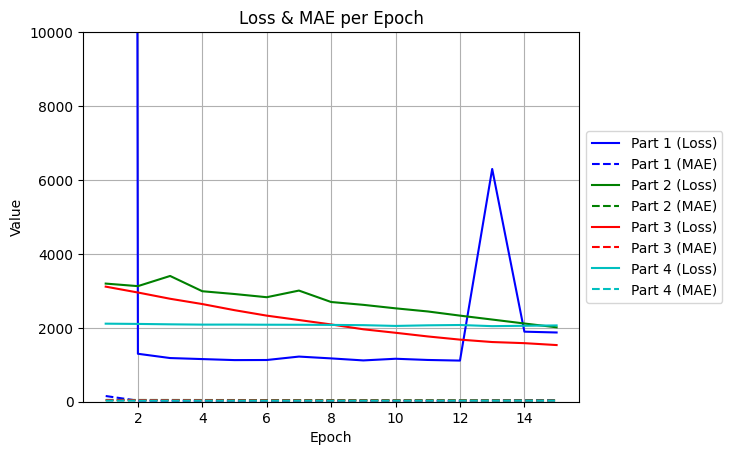

In [17]:
import matplotlib.pyplot as plt

colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

# Itera sobre cada full_history y grafica sus datos

for a in range(len(full_history)):
    # Extrae los valores de loss y mae de la full_history actual
    loss = full_history[a][0]
    mae = full_history[a][1]
    
    # Grafica los valores de loss
    plt.plot(range(1, len(loss) + 1), loss, label=str('Part ')+str(a+1) + ' (Loss)', color=colors[a])
    
    # Grafica los valores de mae
    #plt.plot(range(1, len(mae) + 1), mae, label=str('Part ')+str(a+1) + ' (MAE)', linestyle='dashed', color=colors[a])

# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,10000)

plt.title('Loss & MAE per Epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Coloca la leyenda fuera del gráfico
plt.grid(True)

# Muestra el gráfico
plt.show()


### For 6 NN with 224,224

In [7]:

def separar_imagen(imagen):
    """
    Separa una imagen con dimensiones (224, 224, 6) en 6 imágenes con dimensiones (224, 224, 1).

    Args:
    imagen (numpy.ndarray): Imagen original con dimensiones (224, 224, 6).

    Returns:
    tuple: Una tupla con 6 numpy.ndarrays, cada uno con dimensiones (224, 224, 1).
    """
    # Verificar que la imagen tenga las dimensiones correctas
    assert imagen.shape == (224, 224, 6), "La imagen debe tener dimensiones (224, 224, 6)"
    
    # Separar la imagen en 6 partes
    imagenes_separadas = tuple(imagen[:, :, i][:, :, np.newaxis] for i in range(6))
    
    return imagenes_separadas

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout

def build_model_layer():
    # Crear el modelo secuencial
    model = Sequential()

    # Añadir la capa de convolución 2D
    model.add(Conv2D(filters=8, kernel_size=(1, 1), activation='relu', input_shape=(224, 224, 1)))

    # Añadir la capa de Average Pooling
    model.add(AveragePooling2D(pool_size=(2, 2)))
    # Añadir la capa de convolución 2D
    model.add(Conv2D(filters=8, kernel_size=(1, 1), activation='relu', input_shape=(224, 224, 1)))

    # Añadir la capa de Average Pooling
    model.add(AveragePooling2D(pool_size=(2, 2)))
    # Añadir la capa de convolución 2D
    model.add(Conv2D(filters=8, kernel_size=(1,1), activation='relu', input_shape=(224, 224, 1)))

    # Añadir la capa de Average Pooling
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Aplanar la salida de la capa de pooling
    model.add(Flatten())

    # Añadir una capa densa
    model.add(Dense(units=128, activation='relu'))

    # Añadir la capa de Dropout
    model.add(Dropout(rate=0.5))

    # Añadir la capa de salida con activación lineal
    model.add(Dense(units=1, activation='linear'))
    return model

#### Global settings for the layered models

In [9]:
batch_size = 4000
epochs = 15

#### Model for layer 0

In [40]:
model_0=build_model_layer()
# Compilar el modelo
model_0.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

# Resumen del modelo
model_0.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 224, 224, 8)    │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_48            │ (None, 112, 112, 8)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 112, 112, 8)    │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_49            │ (None, 56, 56, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 56, 56, 8)      │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_50            │ (None, 28, 28, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,233 (3.06 MB)

 Trainable params: 803,233 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Configuración de entrenamiento
full_history_0=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[0],dtype=tf.float32))
    images=np.array(images)
    history=model_0.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_0.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = np.array(mp10[num_parts * batch_size:])
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[0],dtype=tf.float32))
    images=np.array(images)
    history=model_0.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_0.append([history.history['loss'],history.history['mae']])

Part:  1


/tmp/ipykernel_125250/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_125250/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - loss: 1206693.2500 - mae: 304.5829
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 1195.3711 - mae: 26.3200
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - loss: 1195.4224 - mae: 26.3100
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 1191.1312 - mae: 26.1288
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 1181.1414 - mae: 25.9029
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - loss: 1239.9115 - mae: 26.8054
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 1179.6305 - mae: 26.0027
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - loss: 1219.7075 - mae: 26.1816
Epoch 9/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 1149.2811 - mae: 25.9751
Epoch 10/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - loss: 1204.7975 - mae: 26.3093
Epoch 11/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 1254.1559 - mae: 26.1332
Epoch 12/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms

In [19]:
images=[]
for imgs in test_image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[0],dtype=tf.float32))
images=np.array(images)
op_0=model_0.evaluate(images,test_mp10)

/tmp/ipykernel_125250/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_125250/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 2266.4734 - mae: 35.4050


#### Model for layer 1

In [20]:
model_1=build_model_layer()
# Compilar el modelo
model_1.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

In [21]:
# Configuración de entrenamiento
full_history_1=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[1],dtype=tf.float32))
    images=np.array(images)
    history=model_1.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_1.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[1],dtype=tf.float32))
    images=np.array(images)
    
    history=model_1.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_1.append([history.history['loss'],history.history['mae']])

Part:  1


/tmp/ipykernel_125250/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_125250/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - loss: 913001.0000 - mae: 292.4026
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 1226.9545 - mae: 26.4612
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1205.6516 - mae: 26.1389
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 1171.9271 - mae: 26.4060
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 1083.2375 - mae: 24.8937
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 1167.6543 - mae: 25.3367
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 1186.4110 - mae: 24.6925
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 1143.1995 - mae: 25.1576
Epoch 9/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - loss: 1125.3329 - mae: 24.6698
Epoch 10/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1097.0259 - mae: 25.1335
Epoch 11/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 1153.8210 - mae: 25.4151
Epoch 12/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/

In [22]:
images=[]
for imgs in test_image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[1],dtype=tf.float32))
images=np.array(images)
op_1=model_1.evaluate(images,test_mp10)

/tmp/ipykernel_125250/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_125250/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 2041.2612 - mae: 32.4643


#### Model for layer 2

In [23]:
model_2=build_model_layer()
# Compilar el modelo
model_2.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

In [24]:
full_history_2=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[2],dtype=tf.float32))
    images=np.array(images)
    history=model_2.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_2.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[2],dtype=tf.float32))
    images=np.array(images)
    history=model_2.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_2.append([history.history['loss'],history.history['mae']])

Part:  1


/tmp/ipykernel_125250/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_125250/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - loss: 2438089.2500 - mae: 344.5574
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1331.4884 - mae: 28.6620
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1159.0286 - mae: 25.5553
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - loss: 1240.8391 - mae: 26.1500
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - loss: 1138.6880 - mae: 25.8524
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 1182.0438 - mae: 25.0709
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 1095.1334 - mae: 25.0147
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 49712.7734 - mae: 58.7242
Epoch 9/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 2392.8584 - mae: 36.2979
Epoch 10/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 2038.9441 - mae: 37.7682
Epoch 11/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 2116.9963 - mae: 38.6167
Epoch 12/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 174m

In [25]:
images=[]
for imgs in test_image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[2],dtype=tf.float32))
images=np.array(images)
op_2=model_2.evaluate(images,test_mp10)

/tmp/ipykernel_125250/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_125250/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1057.0820 - mae: 21.7910


#### Model for layer 3

In [26]:
model_3=build_model_layer()
# Compilar el modelo
model_3.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

In [27]:
# Configuración de entrenamiento
full_history_3=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[3],dtype=tf.float32))
    images=np.array(images)
    history=model_3.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_3.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[3],dtype=tf.float32))
    images=np.array(images)
    history=model_3.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_3.append([history.history['loss'],history.history['mae']])

Part:  1


/tmp/ipykernel_125250/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_125250/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - loss: 28188018.0000 - mae: 1422.6663
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - loss: 1202.2905 - mae: 26.0352
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - loss: 1152.7028 - mae: 25.9518
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1213.6423 - mae: 26.3431
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1225.3353 - mae: 26.9435
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - loss: 1154.2968 - mae: 26.0986
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1206.5559 - mae: 26.8627
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1151.3319 - mae: 26.4254
Epoch 9/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1241.6066 - mae: 26.6452
Epoch 10/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - loss: 1227.7262 - mae: 26.8630
Epoch 11/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 1223.4122 - mae: 26.5208
Epoch 12/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 173

In [28]:
images=[]
for imgs in test_image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[3],dtype=tf.float32))
images=np.array(images)
op_3=model_3.evaluate(images,test_mp10)

/tmp/ipykernel_125250/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_125250/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2008.0012 - mae: 31.8825


#### Model for layer 4

In [29]:
model_4=build_model_layer()
# Compilar el modelo
model_4.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

In [30]:
full_history_4=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[4],dtype=tf.float32))
    images=np.array(images)
    history=model_4.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_4.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[4],dtype=tf.float32))
    images=np.array(images)
    history=model_4.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_4.append([history.history['loss'],history.history['mae']])

Part:  1


/tmp/ipykernel_125250/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_125250/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - loss: 110128.6953 - mae: 104.5473
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1120.6791 - mae: 25.2662
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 1051.7064 - mae: 24.9220
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1130.5317 - mae: 25.0777
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 999.3138 - mae: 23.3089
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 8394.2490 - mae: 39.3768
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 1450.8536 - mae: 29.9626
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1539.1213 - mae: 30.9083
Epoch 9/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 1584.1271 - mae: 31.2781
Epoch 10/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 1511.0802 - mae: 30.6669
Epoch 11/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 1519.4996 - mae: 30.1745
Epoch 12/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/s

In [31]:
images=[]
for imgs in test_image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[4],dtype=tf.float32))
images=np.array(images)
op_4=model_4.evaluate(images,test_mp10)

/tmp/ipykernel_125250/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_125250/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1206.6593 - mae: 23.3531


#### Model for layer 5

In [32]:
model_5=build_model_layer()
# Compilar el modelo
model_5.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])


In [33]:
# Configuración de entrenamiento
full_history_5=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[5],dtype=tf.float32))
    images=np.array(images)
    history=model_5.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_5.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    images=[]
    for imgs in image_files_part:
        images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[5],dtype=tf.float32))
    images=np.array(images)
    history=model_5.fit(images,mp10_part,epochs=epochs,batch_size=50,shuffle=True)
    full_history_5.append([history.history['loss'],history.history['mae']])

Part:  1


/tmp/ipykernel_125250/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_125250/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - loss: 3278752.2500 - mae: 470.6431
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 1093.1849 - mae: 25.7026
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 1107.2533 - mae: 25.4376
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 1126.1539 - mae: 25.3040
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1140.7649 - mae: 25.6056
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - loss: 1091.8582 - mae: 24.8438
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 1208.2341 - mae: 25.1664
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 1106.1198 - mae: 24.9905
Epoch 9/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 1085.6123 - mae: 25.0638
Epoch 10/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 1118.5215 - mae: 25.0975
Epoch 11/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - loss: 1015.2451 - mae: 24.4979
Epoch 12/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms

In [34]:
images=[]
for imgs in test_image_files:
    images.append(tf.convert_to_tensor(separar_imagen(preprocess_imagery(imgs))[5],dtype=tf.float32))
images=np.array(images)
op_5=model_5.evaluate(images,test_mp10)

/tmp/ipykernel_125250/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_125250/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1717.0421 - mae: 29.2214


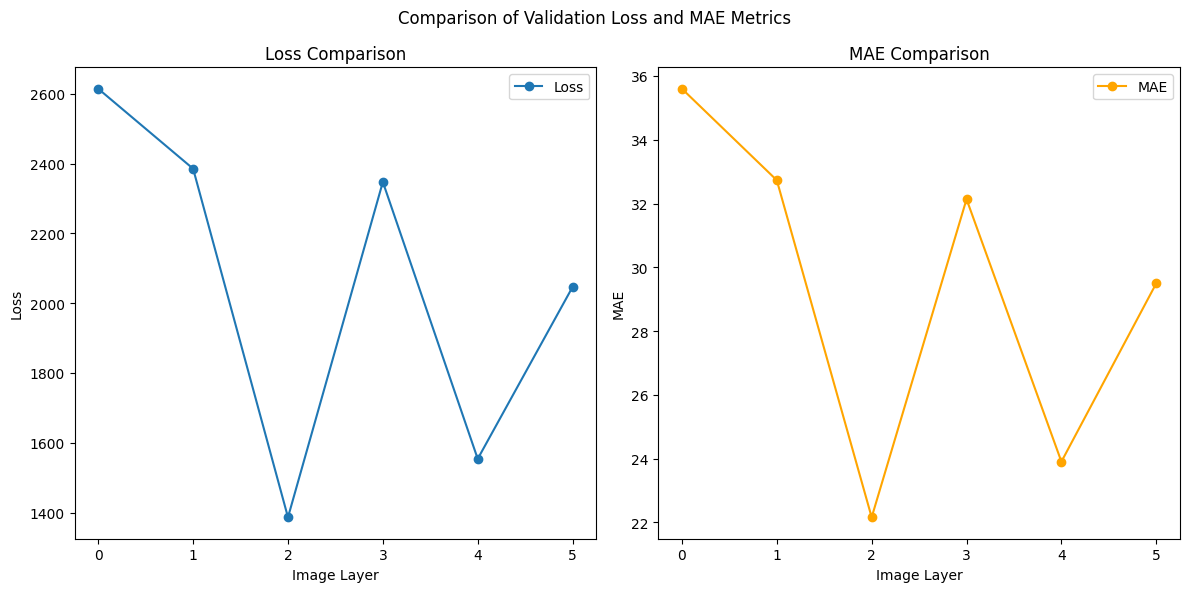

In [35]:
import matplotlib.pyplot as plt

# Assuming you have op_0 to op_5 arrays with loss and MAE values
# Replace these with your actual data

# Extract loss and MAE values
loss_values = [op[0] for op in [op_0, op_1, op_2, op_3, op_4, op_5]]
mae_values = [op[1] for op in [op_0, op_1, op_2, op_3, op_4, op_5]]

# Create subplots for loss and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss
ax1.plot(loss_values, marker='o', label='Loss')
ax1.set_title('Loss Comparison')
ax1.set_xlabel('Image Layer')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE
ax2.plot(mae_values, marker='o', color='orange', label='MAE')
ax2.set_title('MAE Comparison')
ax2.set_xlabel('Image Layer')
ax2.set_ylabel('MAE')
ax2.legend()
plt.suptitle('Comparison of Validation Loss and MAE Metrics')
plt.tight_layout()
plt.savefig('loss & mae val.png',format='png')
plt.show()



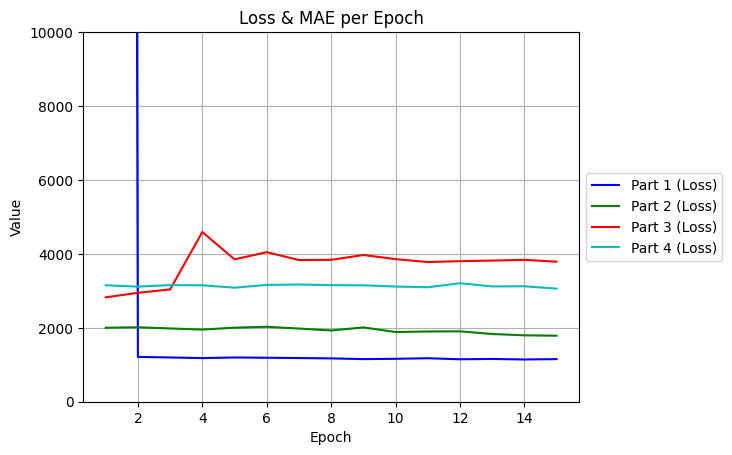

In [36]:
import matplotlib.pyplot as plt

colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

# Itera sobre cada full_history y grafica sus datos

for a in range(len(full_history_0)):
    # Extrae los valores de loss y mae de la full_history actual
    loss = full_history_0[a][0]
    mae = full_history_0[a][1]
    
    # Grafica los valores de loss
    plt.plot(range(1, len(loss) + 1), loss, label=str('Part ')+str(a+1) + ' (Loss)', color=colors[a])
    
    # Grafica los valores de mae
    #plt.plot(range(1, len(mae) + 1), mae, label=str('Part ')+str(a+1) + ' (MAE)', linestyle='dashed', color=colors[a])

# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,10000)

plt.title('Loss & MAE per Epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Coloca la leyenda fuera del gráfico
plt.grid(True)

# Muestra el gráfico
plt.show()


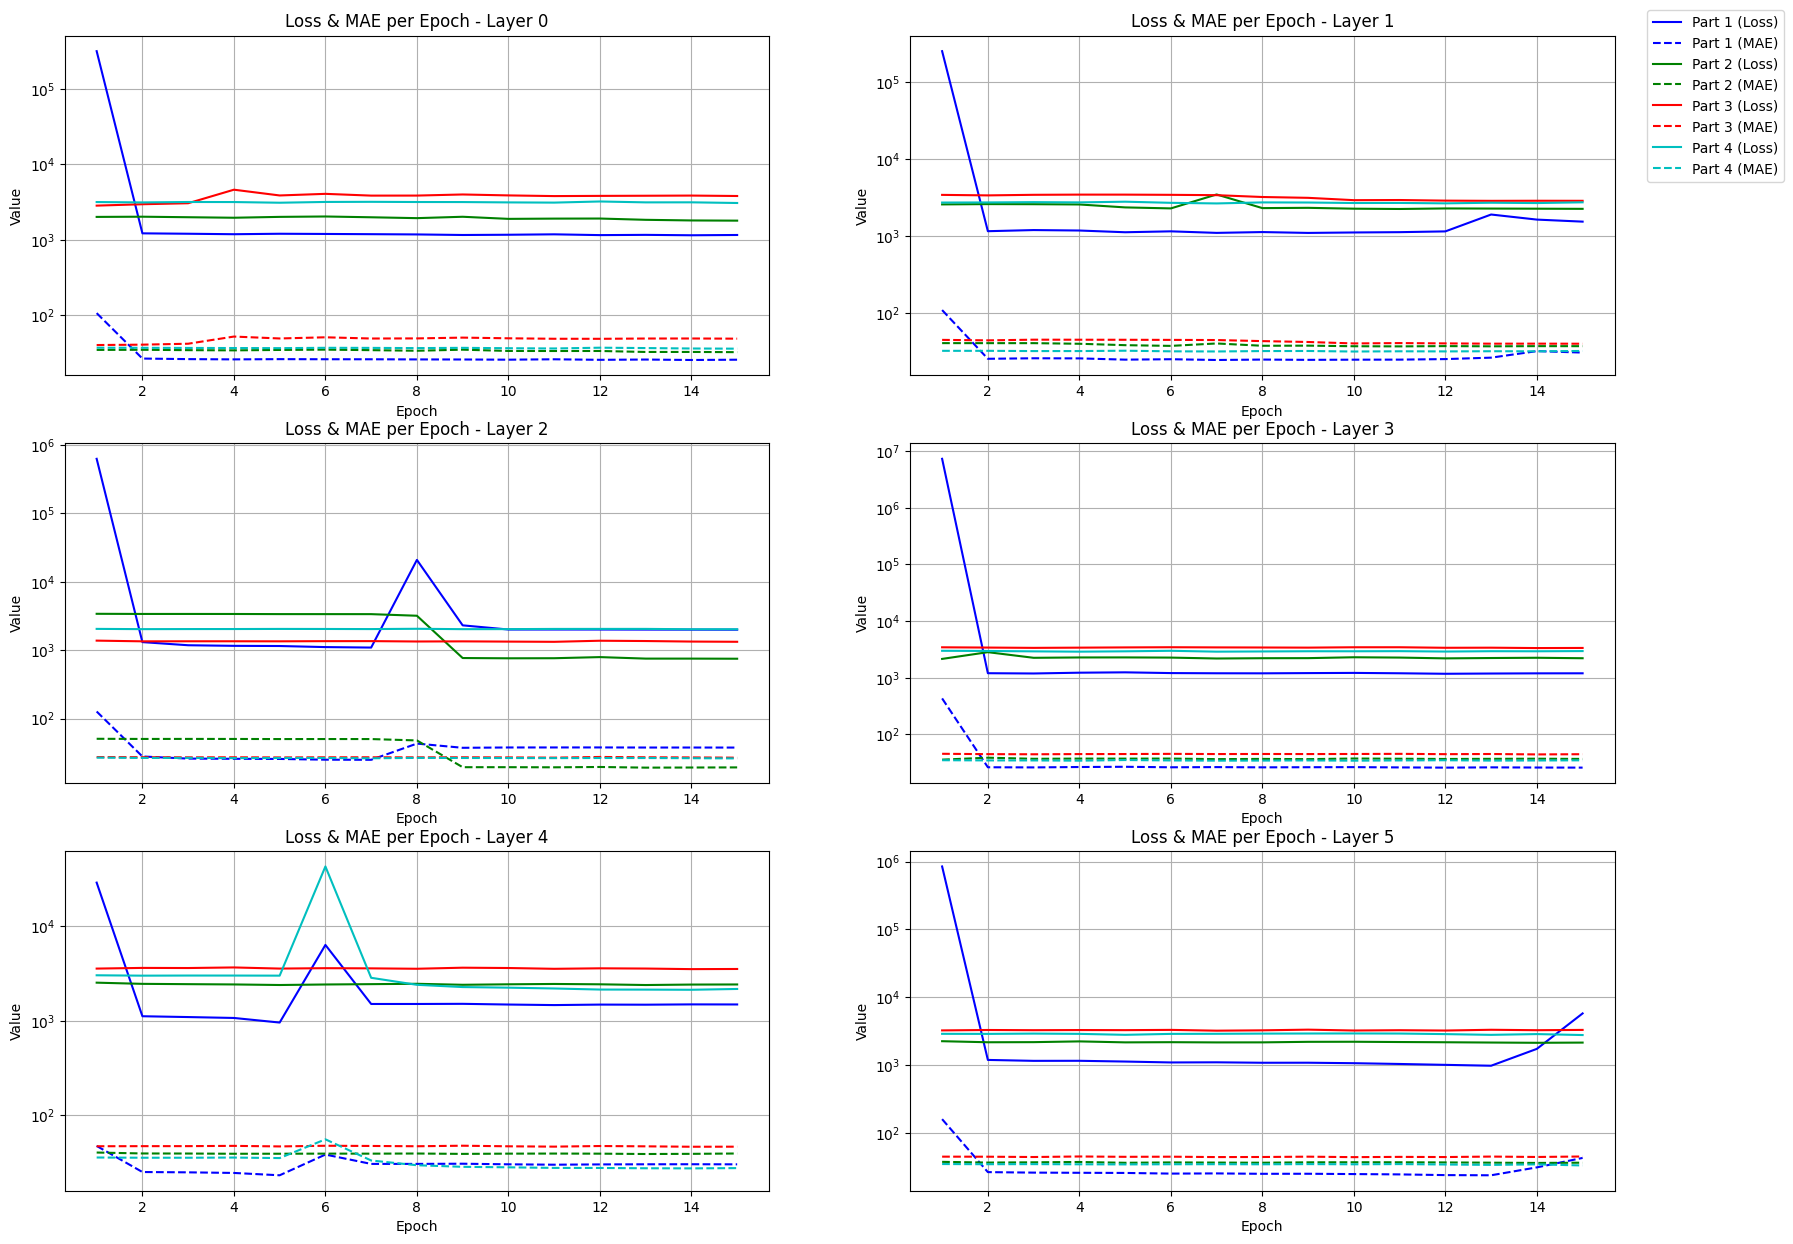

In [37]:
num_filas = 3
num_columnas = 2
full_histories=[full_history_0,full_history_1,full_history_2,full_history_3,full_history_4,full_history_5]
# Crea la figura y los subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(20, 15))
for i in range(num_filas):
    for j in range(num_columnas):
        index = i * num_columnas + j
        if index < len(full_histories):
            for a in range(len(full_histories[i*2+j])):
                # Extrae los valores de loss y mae de la full_history actual
                loss = full_histories[i*2+j][a][0]
                mae = full_histories[i*2+j][a][1]
                
                # Grafica los valores de loss
                axs[i,j].plot(range(1, len(loss) + 1), loss, label=str('Part ')+str(a+1) + ' (Loss)', color=colors[a])
                
                # Grafica los valores de mae
                axs[i,j].plot(range(1, len(mae) + 1), mae, label=str('Part ')+str(a+1) + ' (MAE)', linestyle='dashed', color=colors[a])
                axs[i, j].set_xlabel('Epoch')
                axs[i, j].set_ylabel('Value')
                axs[i,j].set_yscale('symlog')
                axs[i, j].set_title('Loss & MAE per Epoch - Layer {}'.format(index))
                
                axs[i, j].grid(True)
plt.legend(loc='lower right',bbox_to_anchor=(1.25,2.95))
            
plt.savefig('loss & mae layered.png',format='png')

# Muestra la figura
plt.show()

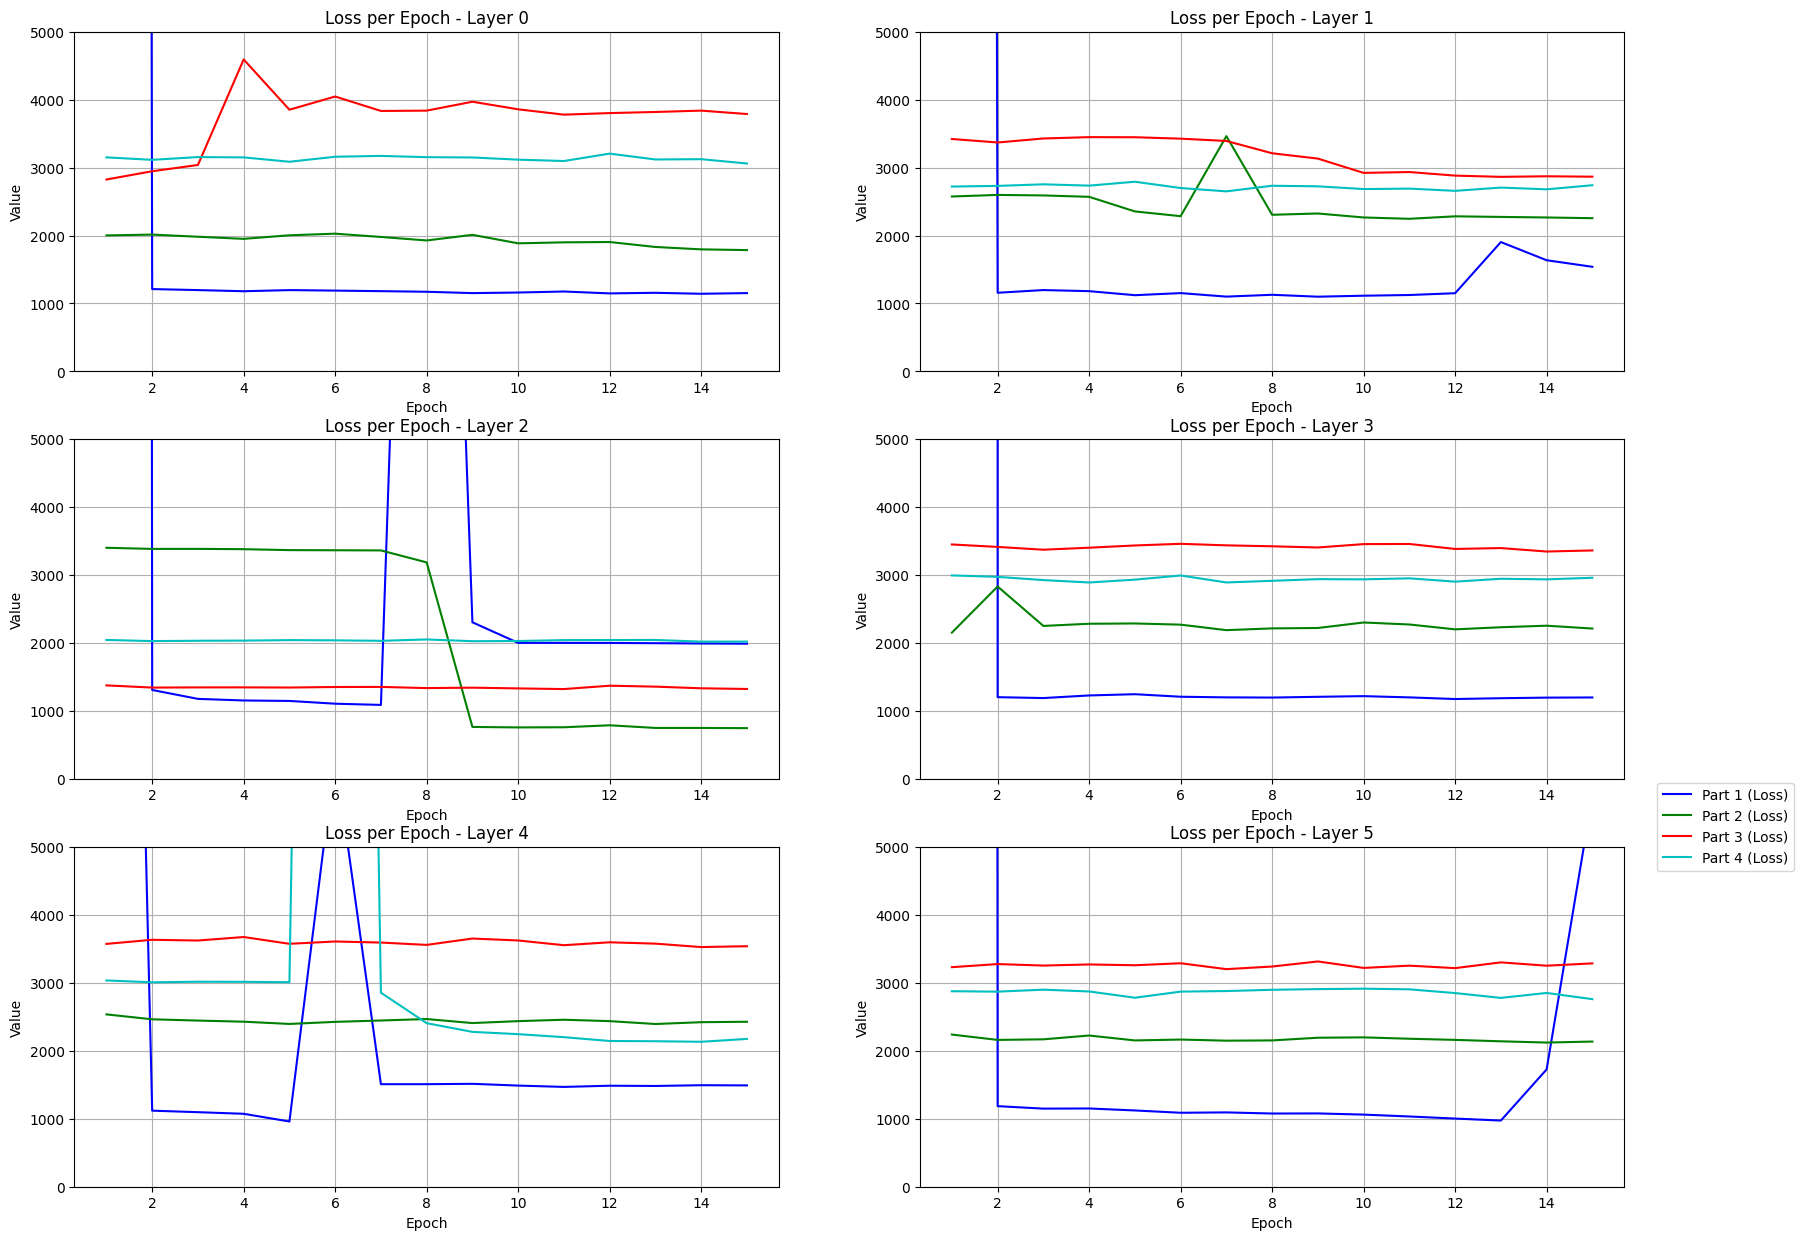

In [38]:
num_filas = 3
num_columnas = 2
full_histories=[full_history_0,full_history_1,full_history_2,full_history_3,full_history_4,full_history_5]
# Crea la figura y los subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(20, 15))
for i in range(num_filas):
    for j in range(num_columnas):
        index = i * num_columnas + j
        if index < len(full_histories):
            for a in range(len(full_histories[i*2+j])):
                # Extrae los valores de loss y mae de la full_history actual
                loss = full_histories[i*2+j][a][0]
                
                # Grafica los valores de loss
                axs[i,j].plot(range(1, len(loss) + 1), loss, label=str('Part ')+str(a+1) + ' (Loss)', color=colors[a])
                axs[i, j].set_xlabel('Epoch')
                axs[i, j].set_ylabel('Value')
                axs[i, j].set_ylim(0,5000)
                axs[i, j].set_title('Loss per Epoch - Layer {}'.format(index))
                
                axs[i, j].grid(True)
plt.legend(loc='lower right',bbox_to_anchor=(1.25,0.91))
            

plt.savefig('loss layered.png',format='png')
# Muestra la figura
plt.show()

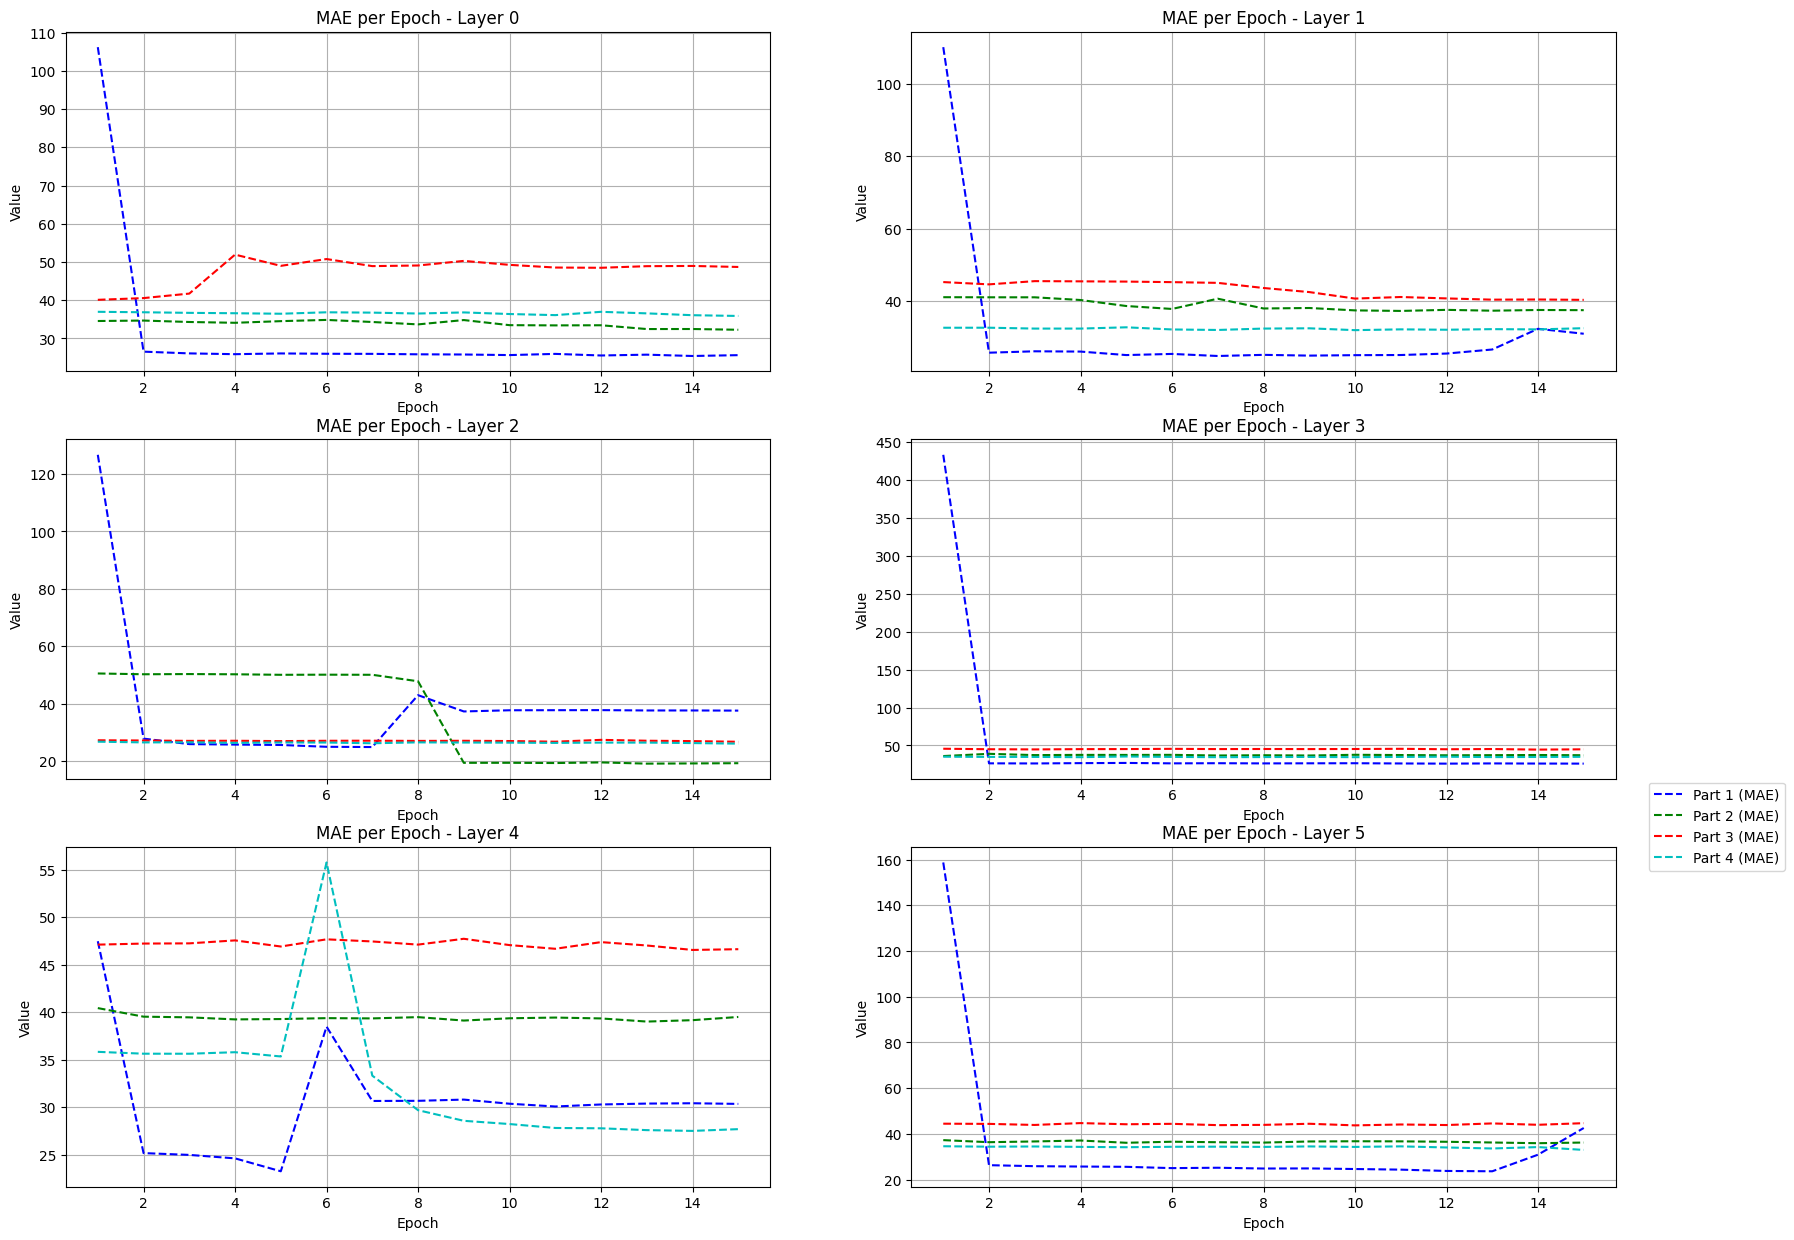

In [39]:
num_filas = 3
num_columnas = 2
full_histories=[full_history_0,full_history_1,full_history_2,full_history_3,full_history_4,full_history_5]
# Crea la figura y los subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(20, 15))
for i in range(num_filas):
    for j in range(num_columnas):
        index = i * num_columnas + j
        if index < len(full_histories):
            for a in range(len(full_histories[i*2+j])):
                # Extrae los valores de loss y mae de la full_history actual
                mae = full_histories[i*2+j][a][1]                
                # Grafica los valores de mae
                axs[i,j].plot(range(1, len(mae) + 1), mae, label=str('Part ')+str(a+1) + ' (MAE)', linestyle='dashed', color=colors[a])
                axs[i, j].set_xlabel('Epoch')
                axs[i, j].set_ylabel('Value')
                
                axs[i, j].set_title('MAE per Epoch - Layer {}'.format(index))
                
                axs[i, j].grid(True)
plt.legend(loc='lower right',bbox_to_anchor=(1.25,0.91))
            
plt.savefig('mae layered.png',format='png')

# Muestra la figura
plt.show()